# Chapter 5: Ta panda rhei

### Generation of animations and interactive plots.

Earth is a dynamic system with changes occuring at any instance. Why not using the same philosophy when we create plots about our environment? 

In this tutorial we will:
1. Search, download, and view data freely available in [Climate Data Store](https://cds.climate.copernicus.eu/cdsapp#!/home).
2. Use country shapefiles for generating country-average fields.
3. Create dynamic outputs in the form of animations and interactive plots.

<style>
td, th {
   border: 1px solid white;
   border-collapse: collapse;
}
</style>
<table align="left">
  <tr>
    <th>Run the tutorial via free cloud platforms: </th>
    <!-- <th><a href="https://mybinder.org/v2/gh/ecmwf-projects/copernicus-training-c3s/main?labpath=reanalysis-climatology.ipynb">
        <img src = "https://mybinder.org/badge.svg" alt = "Binder"></th> -->
    <th><a href="https://kaggle.com/kernels/welcome?src=https://github.com/ECMWFCode4Earth/sketchbook-earth/blob/notebook4/tutorials/04_sea_level/04_sea_level.ipynb">
        <img src = "https://kaggle.com/static/images/open-in-kaggle.svg" alt = "Kaggle"></th>
    <th><a href="https://colab.research.google.com/github/ECMWFCode4Earth/sketchbook-earth/blob/notebook4/tutorials/04_sea_level/04_sea_level.ipynb">
        <img src = "https://colab.research.google.com/assets/colab-badge.svg" alt = "Colab"></th>
  </tr>
</table>

------------------

### Section 1. Install & import the necessary packages.

The first step for being able to analyse and plot the data is to download and import the necessary libraries for this tutorial. In the GitHub repository you can find the full environment that has all the libraries needed for this and the other tutorials. The environment can be installed in Linux with the simple command: `conda env create -f environment.yml`. This would be the best option if you use this and the rest tutorials on your local computer. If you are using this tutorial in Google Colab most of the required libraries are already preinstalled in the environment and there are only few libraries that should be downloaded.

<div class="alert alert-block alert-warning">
    
<b>NOTE</b>: <br>
After you execute the below cell you might be prompted by Google Colab to "Restart the Runtime". If this happens, please restart the runtime and move on the next cell.
</div>

In [1]:
# download libraries not available in the default Google Colab environment
%pip install cdsapi

# need some extra arguments for intalling cartopy otherwise some features of this library break the script if it is run in Google Colab 
%pip install shapely cartopy --no-binary shapely --no-binary cartopy --force # more info at https://github.com/SciTools/cartopy/issues/1490

Let's now import all the required libraries in our environment. We categorized the libraries based on that they are used for: general libraries, libraries for data analysis, and plotting libraries.

In [1]:
# General libraries
import requests # for getting data from url
import os # operating system interfaces library
import cdsapi # CDS API
from datetime import datetime

# Libraries for working with arrays
import numpy as np # for n-d arrays
import pandas as pd # for 2-d arrays
import xarray as xr # for n-d arrays (including metadata for all the dimensions)
import regionmask # library with stored polygons of countries, regions, etc. that can be used for masking xarray data

# Libraries for plotting and visualising data
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from matplotlib.gridspec import GridSpec
from matplotlib.animation import FuncAnimation
from matplotlib.collections import LineCollection
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature

The below is for having a consistent plotting across all tutorials. It **will NOT work in Google Colab** or other cloud services, unless you include the file `copernicus.mplstyle` (available in the Github repository) in the cloud and in the same directory as this notebook, and use the correct path, e.g.
`plt.style.use('copernicus.mplstyle')`.

In [2]:
plt.style.use('../copernicus.mplstyle') # use the predefined matplotlib style for consistent plotting across all tutorials

### Section 2. Download data.

Let's create a folder were all the data will be stored.

In [3]:
dir_loc = 'data/' # assign folder for storing the downloaded data
os.makedirs(f'{dir_loc}', exist_ok=True) # create the folder if not available

Now let's use the `regionmask` [package]((https://regionmask.readthedocs.io/en/stable/index.html#)) to select the region of interest and get the boundary box needed for deriving the data from CDS.

In [4]:
regions = regionmask.defined_regions.natural_earth_v5_0_0.countries_50
regions_gdf = regions.to_geodataframe()
regions_gdf

abbrevs            names   
numbers                            
0            ZW         Zimbabwe  \
1            ZM           Zambia   
2            YE            Yemen   
3            VN          Vietnam   
4            VE        Venezuela   
...         ...              ...   
237          AF      Afghanistan   
238          SG  Siachen Glacier   
239          AQ       Antarctica   
240          SX     Sint Maarten   
241          TV           Tuvalu   

                                                  geometry  
numbers                                                     
0        POLYGON ((31.28789 -22.40205, 31.19727 -22.344...  
1        POLYGON ((30.39609 -15.64307, 30.25068 -15.643...  
2        MULTIPOLYGON (((53.08564 16.64839, 52.58145 16...  
3        MULTIPOLYGON (((104.06396 10.39082, 104.08301 ...  
4        MULTIPOLYGON (((-60.82119 9.13838, -60.94141 9...  
...                                                    ...  
237      POLYGON ((66.52227 37.34849, 66.82773 37.37129...  
238      POLYGON ((77.04863 35.10991, 77.00449 35.19634...  
239      MULTIPOLYGON (((-45.71777 -60.52090, -45.49971...  
240      POLYGON ((-63.12305 18.06895, -63.01118 18.068...  
241      POLYGON ((179.21367 -8.52422, 179.20059 -8.534...  

[242 rows x 3 columns]

<Axes: >

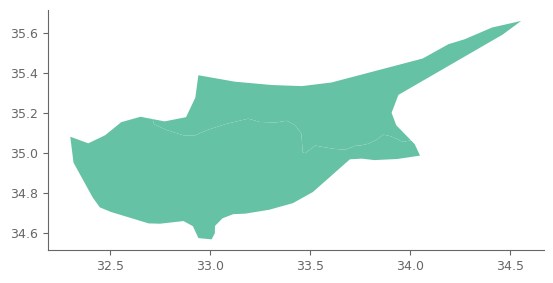

In [5]:
country_used = 'Cyprus'
domains_selected = [i for i in regions_gdf.names.values if country_used in i] # take all regions that contain the country of interest, in case NaturalEarth splits the country in more domains
regions_gdf.query('names in @domains_selected').plot()

Get the boundary box. Because ERA5 Land has a resolution of 0.1 degrees, we will modify the boundaries so that they are increments of 0.1.

In [6]:
boundary_used = regions_gdf.query('names in @domains_selected').total_bounds
boundary_used # the values are given as minx, miny, maxx, maxy

array([32.30097656, 34.56958008, 34.55605469, 35.66206055])

In [7]:
minx, miny = np.floor(boundary_used[:2]*10)/10 # for min values we use floor
maxx, maxy = np.ceil(boundary_used[2:]*10)/10 # for max values we use ceil

Enter CDS API key


We will request data from the Climate Data Store (CDS) programmatically with the help of the CDS API. Let us make use of the option to manually set the CDS API credentials. First, you have to define two variables: `URL` and `KEY` which build together your CDS API key. The string of characters that make up your KEY include your personal User ID and CDS API key. To obtain these, first register or login to the CDS (http://cds.climate.copernicus.eu), then visit https://cds.climate.copernicus.eu/api-how-to and copy the string of characters listed after "key:". Replace the `#########` below with that string.

In [12]:
# CDS key
cds_url = 'https://cds.climate.copernicus.eu/api/v2'
cds_key = '########' # please add your key here the format should be as {uid}:{api-key}

In this tutorial we will work with [temperature data from ERA5 land](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-land-monthly-means?tab=overview), that have finer resolution compared to ERA5.

In [53]:
c = cdsapi.Client(url=cds_url, key=cds_key)

c.retrieve(
    'reanalysis-era5-land-monthly-means',
    {
        'area': [maxy, minx, miny, maxx], # North, West, South, East
        'product_type': 'monthly_averaged_reanalysis',
        'variable': '2m_temperature',
        'year': list(range(1950, 2024)),
        'month': [('0'+str(i))[-2:] for i in list(range(1, 13))], # the months should be given as 2 digit (e.g., '01', '12')
        'time': '00:00',
        'format': 'grib',
    },
    f'{dir_loc}/t2m_{country_used}.grib')

2023-07-30 15:55:36,679 INFO Welcome to the CDS
2023-07-30 15:55:36,680 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-land-monthly-means


2023-07-30 15:55:36,791 INFO Request is queued
2023-07-30 15:55:37,966 INFO Request is running
2023-07-30 16:01:57,572 INFO Request is completed
2023-07-30 16:01:57,573 INFO Downloading https://download-0015-clone.copernicus-climate.eu/cache-compute-0015/cache/data5/adaptor.mars.internal-1690751795.3057384-13173-11-951f6202-e974-425c-8cea-4d89b4f65731.grib to data//t2m_United Kingdom.grib (7.9M)
2023-07-30 16:02:02,587 INFO Download rate 1.6M/s   


Result(content_length=8255520,content_type=application/x-grib,location=https://download-0015-clone.copernicus-climate.eu/cache-compute-0015/cache/data5/adaptor.mars.internal-1690751795.3057384-13173-11-951f6202-e974-425c-8cea-4d89b4f65731.grib)

Read the file.

In [8]:
t2m = xr.open_dataarray(f'{dir_loc}/t2m_{country_used}.grib', engine='cfgrib')
t2m

<xarray.DataArray 't2m' (time: 882, latitude: 13, longitude: 24)>
[275184 values with dtype=float32]
Coordinates:
    number      int64 ...
  * time        (time) datetime64[ns] 1950-01-01 1950-02-01 ... 2023-06-01
    step        timedelta64[ns] ...
    surface     float64 ...
  * latitude    (latitude) float64 35.7 35.6 35.5 35.4 ... 34.8 34.7 34.6 34.5
  * longitude   (longitude) float64 32.3 32.4 32.5 32.6 ... 34.3 34.4 34.5 34.6
    valid_time  (time) datetime64[ns] ...
Attributes: (12/30)
    GRIB_paramId:                             167
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      312
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            avgid
    ...                                       ...
    GRIB_shortName:                           2t
    GRIB_totalNumber:                         0
    GRIB_units:                               K
    long_name:                                2 metre temperature
    units:                                    K
    standard_name:                            unknown

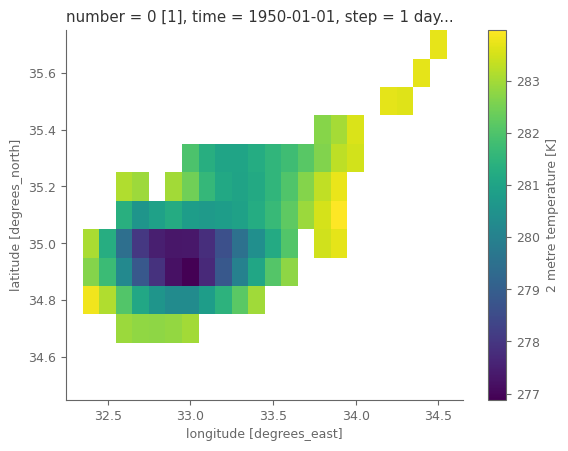

In [9]:
# "quick and dirty" plot of the data
t2m.isel(time=0).plot()

ERA5 Land has the finest resolution possible for a global reanalysis model, nevetheless we can notice that it cannot fully depict the spatial domain of the country.

Let's now use `regionask` for marking the temperature data so that only the grids over the selected country as used.

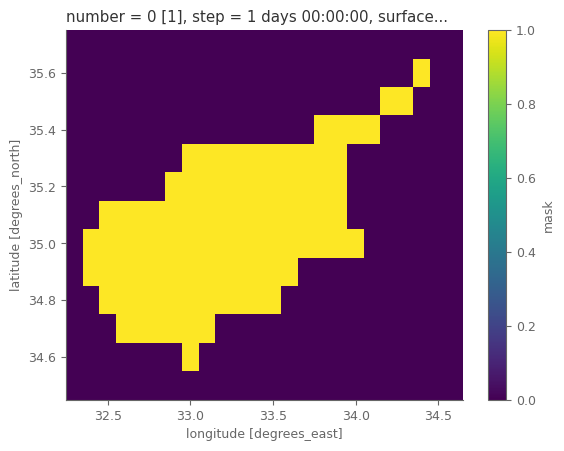

In [10]:
mask_countries = regionmask.defined_regions.natural_earth_v5_0_0.countries_50.mask_3D(t2m, lon_name='longitude', lat_name='latitude') # masks for the regions in the subdomain of the downloaded data
masks_selected = [i for i,j in enumerate(mask_countries.names.values) if country_used in j] # keep the masks only for the domains of interest
mask_country = mask_countries.isel(region=masks_selected).max('region') # in case the country is seperated in more regions, we combine the regions to one mask
mask_country = mask_country*1 # convert to 0-1 from boolean
mask_country.plot()

### Section 3. Data analysis and plotting

We will now use the country of interest for deriving the average temperature timeseries. The data are projected in lat/lon system. This system does not have equal areas for all grid cells, but as we move closer to the poles, the areas of the cells are reducing. These differences can be accounted when weighting the cells with the cosine of their latitude.

In [11]:
weights = np.cos(np.deg2rad(t2m.latitude))
average_t2m_country = t2m.weighted(mask_country * weights).mean(dim=("latitude", "longitude"))
average_t2m_country.to_dataset() # we use 'dataset' object instead of 'dataarray' so that the information are visually nicer 

<xarray.Dataset>
Dimensions:     (time: 882)
Coordinates:
    number      int64 0
  * time        (time) datetime64[ns] 1950-01-01 1950-02-01 ... 2023-06-01
    step        timedelta64[ns] 1 days
    surface     float64 0.0
    valid_time  (time) datetime64[ns] 1950-01-02 1950-02-02 ... 2023-06-02
Data variables:
    t2m         (time) float64 281.3 282.4 286.0 291.0 ... 289.5 293.1 297.4

Let's convert the temperature to Celsius from Kelvin, as the former is used more commonly.

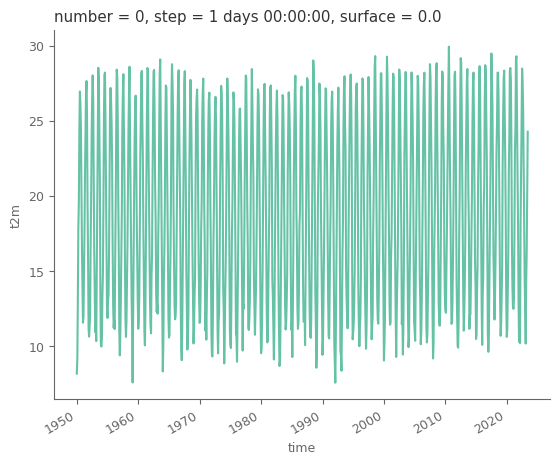

In [12]:
average_t2m_country = average_t2m_country - 273.15
average_t2m_country.plot()

Now that we have the average temperature for the country of interest it's time to generate the plots. But first let's have the country name in ISO format, so that we can attach on the plot the country's flag.

In [13]:
# get ISO names for the countries
iso_codes = pd.read_html("https://www.iban.com/country-codes")[0]

# just in case there are more than 1 regions for one country from regionmask, combine the shapefiles
country_final = regions_gdf.query('names in @domains_selected').drop(columns='abbrevs')
country_final['combo'] = 0
country_final = country_final.dissolve(by='combo')
country_final['names'] = country_used

# because names have differences, be more loose for preventing bugs (is not checked for all countries!)
iso_codes = iso_codes.iloc[iso_codes.Country.str.contains(country_used).values]
iso_codes['Country'] = country_used

country_final = country_final.merge(iso_codes, left_on='names', right_on='Country')
country_final

geometry   names Country   
0  POLYGON ((34.02363 35.04556, 34.05020 34.98838...  Cyprus  Cyprus  \

  Alpha-2 code Alpha-3 code  Numeric  
0           CY          CYP      196

Get the country's flag. We will use png files available in [country-flags repository](https://github.com/hampusborgos/country-flags).

In [14]:
iso_2digits_name = country_final['Alpha-2 code'].values[0].lower()
url_address = f'https://cdn.jsdelivr.net/gh/hampusborgos/country-flags@main/png1000px/{iso_2digits_name}.png'
img_data = requests.get(url_address).content
with open(f'{dir_loc}/flag_{country_used}.png', 'wb') as handler:
    handler.write(img_data)

Now let's create a plot for a particular month each time.

In [15]:
month_of_interest = 'March'

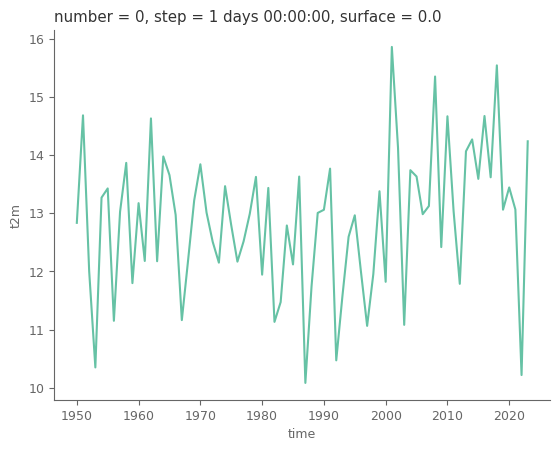

In [16]:
final_timeseries = average_t2m_country.isel(time= (average_t2m_country.time.dt.strftime('%B')==month_of_interest) )
final_timeseries = final_timeseries.assign_coords({'time': final_timeseries.time.dt.strftime('%Y').astype(int)})
final_timeseries.plot()

Let's calculate the linear trend in our data so we can add this information on the animation.

In [17]:
fit_line = final_timeseries.polyfit(dim='time', deg=1)['polyfit_coefficients'] # fit linear trend
linear_fit = fit_line[0]*final_timeseries.time + fit_line[1] # get fitted timeseries based on linear trend

In [18]:
# get colors used for the data. Use Red-Blue colorbar, and allocate the colors after sorting the values
colors_order = np.argsort(np.argsort(final_timeseries.values)) # get the order of the colors
cmap_colors = sns.color_palette("RdBu_r", as_cmap=False, n_colors=len(final_timeseries)) # get same number of colors as the values in the timeseries
cmap_colors = np.array(cmap_colors)[colors_order] # order the colors so they align with the sorted values of the

In [19]:
# get min and max values for the y-axis
min_yaxis = np.floor(final_timeseries.min().values)
max_yaxis = np.ceil(final_timeseries.max().values)

In [20]:
fig = plt.figure(figsize=(11, 5), layout='constrained') # generate the figure
fig.patch.set_facecolor('black') # change figure's background to black

gs = GridSpec(18, 20, figure=fig) # use GridSpec for non-regular subplots of the figure
bpax = plt.subplot(gs[3:, :17]) # create the axis for the basic plot
gmax = plt.subplot(gs[3:9, 17:20], # axis used for plotting the country on the global map
                 projection=ccrs.Orthographic(central_latitude=country_final.centroid.y.values[0],
                                              central_longitude=country_final.centroid.x.values[0])) 
cpax = plt.subplot(gs[9:15, 17:20]) # axis for adding the country's map
flax = plt.subplot(gs[16:, 17:20]) # axis for adding the country's flag

gmax.set_facecolor('grey') # change axis' background to black
gmax.add_geometries(country_final.geometry, crs=ccrs.PlateCarree(), edgecolor='red', facecolor='red', linewidth=2, zorder =20)
gmax.add_feature(cfeature.OCEAN, edgecolor='lightblue', lw=.5) # add the oceans as polygons from the cartopy library
gmax.add_feature(cfeature.BORDERS, edgecolor='0.1', lw=.1)
gmax.coastlines(edgecolor='0.1', lw=.3)
gmax.set_global()

txt_title_kws = dict(size=15, weight=500, ha='left', va='top', transform=bpax.transAxes) # arguments for text (as main title)
year_title = bpax.text(.0, 1.3, f'2m temperature (\u2103), month: {month_of_interest}, country: {country_used}', **txt_title_kws)

dates = final_timeseries.coords['time'].values # get dates

bpax.set_xlim(min(dates)-1, max(dates)+1) # specify the xlim of the plot (extend by 1 year both start/end)
bpax.set_xticks(dates[::4]) # add ticks every 4 years
bpax.set_ylim(min_yaxis, max_yaxis) # add limit of y-axis
bpax.set_facecolor('black') # change axis' background to black
sns.despine(ax=bpax, trim=True, offset=5) # trim the x and y lines

cpax.set_facecolor('black') # change axis' background to black
cpax.set_axis_off()
country_final.plot(ax=cpax)

country_flag = plt.imread(f'{dir_loc}flag_{country_used}.png', format='png')
flax.imshow(country_flag, aspect='equal')
flax.set_axis_off()

def update(frame):
    # for each frame, update the data stored on each artist.
    # we plot 1 more frame for adding the trend at the end, so for last frame, use the year of the previous frame
    if frame==final_timeseries.size:
        current_year = final_timeseries.coords['time'][frame-1].item() # get current year
    else:
        current_year = final_timeseries.coords['time'][frame].item() # get current year
    bpax.set_title(current_year, loc='left', pad=15) # add title of the axis plot
    
    line = bpax.plot(final_timeseries.time[:frame], final_timeseries.values[:frame], c='1', linestyle='--', zorder=1) # white dashed line 
    scat = bpax.scatter(final_timeseries.time[:frame], final_timeseries.values[:frame], c=cmap_colors[:frame], s=50, zorder=10) # colored scatter
    
    # for the last frame add the linear trend
    if frame==final_timeseries.size:
        trend = bpax.plot(linear_fit.time, linear_fit.values, c='gold', linestyle='--', zorder=20) # trend data at the end of the animation
        bpax.text(0.99, 0.05, f'Linear trend: {10*fit_line[0].values: 0.2f} \u2103/decade', 
                 size=12, transform=bpax.transAxes, color='gold', ha='right') # magnitude of linear trend

# plt.close() # close the initial static plot as it is redundant

In [21]:
# Create the animation
ani = FuncAnimation(fig, update, frames=final_timeseries.size+1)

# Display the animation in a Jupyter notebook
from IPython.display import HTML
HTML(ani.to_jshtml())